In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
# I just think XOR is a nice problem that easily introduces
# vanishing gradients on a naive setup using MSE

xs = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
ys = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

In [4]:
# Toy example using 0 fancy features except the autograd for backprop

class Activation: pass
class ReLU(Activation):
    def __call__(self, val: torch.Tensor):
        return val.relu()
class Sigmoid(Activation):
    def __call__(self, val: torch.Tensor):
        return val.sigmoid()
class Tanh(Activation):
    def __call__(self, val: torch.Tensor):
        return val.tanh()

class Layer:
    def __init__(self, inp, out): # out == number of neurons
        torch.manual_seed(2468)
        # Note: for some reason, reshape(R, C) disables the gradients
        self.w = torch.rand(out, inp, requires_grad=True, dtype=torch.float32)  
        self.b = torch.rand(out, 1, requires_grad=True, dtype=torch.float32)

    def forward(self, x):
        # (N, I) . (I, 1) + (N, 1) = (N, 1)
        # print("W=", self.w.shape, " @ X=", x.shape, " + B=", self.b.shape)
        return self.w @ x + self.b
       

class MLP:
    def __init__(self, nout, lrate, layers: list[Layer]):
        self.nout = nout
        self.lrate = lrate
        self.layers = layers
        self.losses = []

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, Layer):
                x = layer.forward(x)
            elif isinstance(layer, Activation):
                x = layer(x)
            else:
                raise ValueError("Unknown layer type")
        if x.numel() != self.nout:
            raise ValueError(f"MLP expects {self.nout} outputs, got {x.numel()} instead")
        return x

    def train(self, epoch=100):
        for i in range(epoch):
            self.reset()
            loss = 0.0
            total = 0.0
            for x, y in zip(xs, ys):
                h = self.forward(x.view(len(x), 1))
                inner = (h - y.reshape(self.nout, 1)) ** 2
                total += inner.numel()
                loss += torch.sum(inner)

            loss = loss / total
            self.losses.append(loss.data)

            loss.backward()

            self.optimize()

        print(f"{i+1}.. Loss {loss.item()}")
        return self


    def reset(self):
        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.w.grad = None
                layer.b.grad = None

    def optimize(self):
        for layer in self.layers:
            if isinstance(layer, Layer):
                with torch.no_grad():
                    layer.w.data += -self.lrate * layer.w.grad
                    layer.b.data += -self.lrate * layer.b.grad

500.. Loss 0.24902105331420898


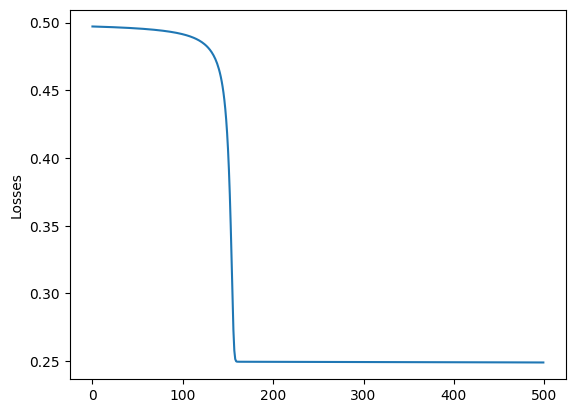

In [5]:

# This setup is completely arbitrary
# but we basically want to overfit for XOR
nout = 1
lrate = 0.1
mlp = MLP(nout, lrate, [
    Layer(2, 4),
    Sigmoid(),
    Layer(4, 5),
    Tanh(),
    Layer(5, 1),
    Tanh(),
]).train(epoch=500)

plt.plot(mlp.losses)
plt.ylabel("Losses")
plt.show()

In [6]:
def overengineered_bad_xor(a, b):
    with torch.no_grad():
        return mlp.forward(torch.tensor([[[a], [b]]], dtype=torch.float32)).data

overengineered_bad_xor(1, 1), overengineered_bad_xor(0, 0), overengineered_bad_xor(1, 0), overengineered_bad_xor(0, 1),


(tensor([[[0.5062]]]),
 tensor([[[0.4920]]]),
 tensor([[[0.5010]]]),
 tensor([[[0.5012]]]))